<center> <h1> SentiNet </h1>

SentiNet is a sentiment analysis system powered by deep learning, built on the Large Movie Review Dataset (https://ai.stanford.edu/~amaas/data/sentiment/). This project leverages TensorFlow's data API for efficient data loading, implements custom sentence embeddings trained from scratch, and uses an MLP for classification. The model is developed with Keras, incorporating advanced training techniques like Nesterov optimization, kernel weight decay, dropout, early stopping, and exponential learning rate scheduling. The final model is ready for deployment with a Gradio web UI and Docker support for seamless installation.

The Large Movie Review Dataset contains 25,000 files for training and 25,000 for testing. I will split the test subset in half to create separate test and validation sets.

## Imports & Setup

In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras

TRAIN_PATH = r"aclImdb_v1\aclImdb\train"
TEST_VAL_PATH = r"aclImdb_v1\aclImdb\test"
BATCH_SIZE = 32
RANDOM_SEED = 42
SHUFFLE_BUFFER = 8192
EMBEDDING_DIM = 128
VOCAB_SIZE = 25000

keras.utils.set_random_seed(42)
keras.backend.backend()

'tensorflow'

In [ ]:
# DOWNLOAD DATASET

DATASET_LINK = "https://ai.stanford.edu/~amaas/data/sentiment/"
keras.utils.get_file(origin=DATASET_LINK, extract=True)

## TensorFlow Data Loader

The TensorFlow Data API is a powerful tool for creating efficient datasets for neural network training, especially when data exceeds memory capacity. It loads data from disk in batches and applies transformations on-the-fly.

This project designs a TensorFlow Data Loader with the following steps:

1. Create a dataset of file paths from all text files within subdirectories of the main directory.
2. Apply a `parse_txt` function to each file path, which:
   - Reads the text file content.
   - If `infer_labels` is enabled, extracts the subdirectory name from the file path, infers it as the label, and encodes it as an integer.
   - Returns a tuple of `(text, label)` if labels are inferred, otherwise returns only the text.
3. Generate a complete dataset of text tensors (and labels if inferred).
4. Provide an optional dataset split for training and validation. When enabled, the dataset is divided based on the specified validation split proportion. Users must specify `subset` as either "training" or "validation" to retrieve the corresponding split.
5. Cache the dataset in memory to accelerate operations (suitable for small datasets), then shuffle, batch, and prefetch batches to optimize training performance.

**Notes:**
- When a `tf.data.Dataset` is passed to Keras' `model.fit`, it automatically interprets tuples as `(input, label)`.
- If the dataset is batched, Keras respects the dataset's batch size, and changing the batch size in `model.fit` has no effect.

In [5]:
# DATA PIPELINE

def parse_txt(path, subdirs, infer_labels=True):
    """Parses a text file and optionally infers its label from the directory structure.
    
    Args:
        path: String, path to the text file.
        subdirs: List of subdirectory names representing classes.
        infer_labels: Bool, whether to infer labels from directory names.
    
    Returns:
        Tuple of (text, label) if infer_labels is True, else only text.
    """
    text = tf.io.read_file(path)
    if infer_labels:
        text_label = tf.strings.split(path, sep=os.sep)[-2]
        label_indices = tf.equal(text_label, tf.constant(subdirs))
        label = tf.argmax(tf.cast(label_indices, tf.int32))
        return (tf.ensure_shape(text, shape=[]), tf.ensure_shape(label, shape=[]))
    return tf.ensure_shape(text, shape=[])


def dataset_from_text_files(data_path, infer_labels=True, batch_size=32, validation_split=False,
                            validation_split_size=0.2, subset="training", shuffle_buffer=500, 
                            prefetch_size=2, seed=42):
    """Creates a TensorFlow dataset from text files with optional train/validation split.
    
    Args:
        data_path: String, path to the directory containing text files.
        infer_labels: Bool, whether to infer labels from directory structure.
        batch_size: Int, size of batches for the dataset.
        validation_split: Bool, whether to split dataset into train/validation.
        validation_split_size: Float, proportion of data for validation.
        subset: String, either 'training' or 'validation' for split.
        shuffle_buffer: Int, buffer size for shuffling.
        prefetch_size: Int, number of batches to prefetch.
        seed: Int, random seed for shuffling.
    
    Returns:
        A TensorFlow dataset, batched and optimized for training or validation.
    """
    subdirs = next(os.walk(data_path))[1]
    path_ds = tf.data.Dataset.list_files(data_path + "/*/*", shuffle=True, seed=seed)
    print(f"Found {path_ds.cardinality().numpy()} text files belonging to {len(subdirs)} classes.")
    dataset = path_ds.map(lambda p: parse_txt(p, infer_labels=infer_labels, subdirs=subdirs), 
                          num_parallel_calls=tf.data.AUTOTUNE)
    full_dataset_size = dataset.cardinality().numpy()
          
    if validation_split and subset == "training":
        train_proportion = tf.round((1 - validation_split_size) * full_dataset_size).numpy()
        dataset = dataset.take(train_proportion)
        print(f"Splitted dataset with {dataset.cardinality().numpy()} train files.")
    
    if validation_split and subset == "validation":
        train_proportion = tf.round((1 - validation_split_size) * full_dataset_size).numpy()
        dataset = dataset.skip(train_proportion)
        print(f"Splitted dataset with {dataset.cardinality().numpy()} validation files.")

    return dataset.cache().shuffle(shuffle_buffer, seed=seed)\
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(prefetch_size)

In [3]:
train_ds = dataset_from_text_files(TRAIN_PATH, infer_labels=True, batch_size=BATCH_SIZE,
                             shuffle_buffer=SHUFFLE_BUFFER,prefetch_size=2, seed=RANDOM_SEED)
                                
# SPLITTING TEST FILES TO TEST AND VAL SUBSETS
val_ds = dataset_from_text_files(TEST_VAL_PATH, infer_labels=True, batch_size=BATCH_SIZE, validation_split=True,
                      validation_split_size=0.5, subset="training", shuffle_buffer=SHUFFLE_BUFFER,prefetch_size=2, seed=BATCH_SIZE)

test_ds = dataset_from_text_files(TEST_VAL_PATH, infer_labels=True, batch_size=BATCH_SIZE, validation_split=True,
                      validation_split_size=0.5, subset="validation", shuffle_buffer=SHUFFLE_BUFFER,prefetch_size=2, seed=BATCH_SIZE)

# PRINT A SAMPLE
sample = train_ds.take(1).get_single_element()
print(f"== REVIEW TEXT == \n {sample[0][0]} \n == LABEL: {sample[1][0]} ==") # LABEL 0 FOR NEG AND 1 FOR POS

Found 25000 text files belonging to 2 classes.
Found 25000 text files belonging to 2 classes.
Splitted dataset with 12500 train files.
Found 25000 text files belonging to 2 classes.
Splitted dataset with 12500 validation files.
== REVIEW TEXT == 
 b'I still don\'t know why I forced myself to sit through the whole thing. This "film" wasn\'t worth the Memorex DVD-R it was burned on; I thought I was watching the end result of a group of middle schoolers stealing their parents\' camcorder. This is by far the worst movie ever made. I truly, from the bottom of my heart, want to sue Aaron Yamasato for the two hours he stole from my life.<br /><br />So apparently, it\'s supposed to be bad on purpose; However, if you should end up in Hell and are forced to watch this 90-minute coil of doo-doo, you\'ll see that Yamasato is really trying hard to make an awesome flick. The actors attempt dramatic kick-ass performances comparable to Crimson Tide but come closer to The Marine.<br /><br />The crap ac

## Modeling

**Sentiment Analysis System Overview**

This project builds a sentiment analysis system using two core components: a custom TensorFlow Data API loader to process text reviews into a tf.data.Dataset, and a Keras-based pipeline for preprocessing, encoding, embedding, and classifying text reviews.

---
**Preprocessing & Encoding**

- A `keras.layers.TextVectorization` layer preprocesses, tokenizes, and integer-encodes text reviews.
- A custom preprocessing function uses tf.strings operations to ensure TensorFlow graph compatibility, removing URLs, numbers, punctuation, stopwords, and excess whitespace while converting text to lowercase.
- A limited vocabulary (`VOCAB_SIZE`) is created by adapting the layer to the training data.
- The output is a tuple of `(vector, label)`, where the vector is an integer-encoded representation of a review based on word presence.

In [7]:
def custom_prep(text):
    """Preprocesses text by normalizing and cleaning it"""
    text = tf.strings.lower(text)  # lowercase
    text = tf.strings.regex_replace(text, pattern=r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*'
                                    , rewrite=" URL ") # remove urls
    text = tf.strings.regex_replace(text, pattern=r'(\#{1,6}\s*)|(\*{1,2})|(__)|(\~\~)|`{1,3}|!\[.*?\]\(.*?\)|\[.*?\]\(.*?\)|<.*?>', rewrite=" ") # remove markdowns
    text = tf.strings.regex_replace(text, pattern=r'\n', rewrite=" ")  # remove newlines
    text = tf.strings.regex_replace(text, pattern=r'[^\w\s]', rewrite=" ")  # remove punctuation
    text = tf.strings.regex_replace(text, pattern=r'\d+', rewrite=" NUMBER ")  # remove Numbers
    text = tf.strings.regex_replace(text, pattern="nbsp" , rewrite=" ")
    stopwords = ['the', 'a', 'an', 'of', 'on', 'in', 'at', 'for', 'to',
     'and', 'or', 'but', 'with', 'by', 'from', 'as', 'that',
     'this', 'these', 'those', 'which', 'who', 'whom', 'whose',
     'there', 'here', 'when', 'where', 'why', 'how']
    pattern = r'\b(' + '|'.join(stopwords) + r')\b'
    text = tf.strings.regex_replace(text,pattern=pattern , rewrite=" ") # remove stopwords
    text = tf.strings.regex_replace(text, pattern=r'\s+', rewrite=" ")  # Whitespace collapse
    return tf.strings.strip(text)

In [10]:
def get_vocab(train_data , vocab_path = "saved_models/vocab.joblib", max_tokens=VOCAB_SIZE, rewrite=False):
    """Save TextVectorizer's vocabulary into disk and load it for subsequent runs. to speed up experiments."""
    import joblib
    if os.path.exists(vocab_path) and rewrite==False:
        print(f"vocab file exist! loading from disk...")
        return joblib.load(vocab_path)
    else:
        print(f"vocab file not exist! adapting from training set...")
        encoder = keras.layers.TextVectorization(output_mode="int", max_tokens=max_tokens, standardize=custom_prep)
        encoder.adapt(train_data)
        vocab = encoder.get_vocabulary()
        joblib.dump(vocab, vocab_path)
        return vocab

train_ds_no_label = train_ds.map(lambda t,l: t, num_parallel_calls=tf.data.AUTOTUNE)
vocab = get_vocab(train_ds_no_label, rewrite=False)

vocab file exist! loading from disk...


**Sentence Embedding**
  
A custom `SentenceEmbedding` layer implements representation learning to create sentence-level embeddings.
It takes an integer-encoded review vector, computes the mean of word embeddings, and normalizes by the square root of the word count to prevent bias from longer reviews.
The embedding matrix has a rank equal to the encoder's vocabulary size, with the output dimension as a tunable hyperparameter.

In [8]:
class SentenceEmbedding(keras.layers.Layer):
    """Custom layer for sentence embeddings using word embeddings and mean pooling.
    
    This layer converts tokenized text into dense sentence embeddings by:
    1. Applying an embedding layer to convert tokens into dense vectors.
    2. Computing the mean of word embeddings across the sequence.
    3. Scaling the mean by the square root of non-zero token counts to account for sequence length.
    
    Args:
        vocab_size: Integer, size of the vocabulary for the embedding layer.
        embedding_dim: Integer, dimensionality of the embedding vectors.
        **kwargs: Additional arguments passed to the parent Layer class.
    
    Raises:
        ValueError: If vocab_size or embedding_dim is not a positive integer.
    
    Returns:
        Tensor of shape (batch_size, embedding_dim) representing sentence embeddings.
    
    Example:
        ```python
        layer = SentenceEmbedding(vocab_size=10000, embedding_dim=128)
        inputs = tf.constant([[1, 2, 0], [3, 4, 5]])  # Tokenized input
        outputs = layer(inputs)  # Sentence embeddings
        ```
    """
    def __init__(self, vocab_size, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        if vocab_size <= 0 or embedding_dim <= 0:
            raise ValueError("vocab_size and embedding_dim must be positive integers")
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
    
    def call(self, X):
        embeddings = self.embedding(X)
        mean = keras.ops.mean(embeddings, axis=1)  
        reviews_word_count = keras.ops.count_nonzero(X, axis=1) 
        sqrt_root = keras.ops.sqrt(keras.ops.cast(reviews_word_count, "float32") + 1e-10) 
        return mean * keras.ops.expand_dims(sqrt_root, axis=-1)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "vocab_size": self.vocab_size, "embedding_dim": self.embedding_dim}

**MLP Classifier**

The MLP classifier consists of a dense layer with 512 units, a 50% dropout layer, and a 32-unit dense layer.
ReLU activation and He normal initialization are used for efficient non-linear feature capture.
A final dense layer with sigmoid activation outputs the sentiment prediction.

In [22]:
def get_model(vocab, embedding_in , embedding_dim,  model_name="seq_model"):
    """Builds a sentiment analysis model with text vectorization, Sentence Embedding and MLP."""
    model = keras.models.Sequential(name=model_name)
    model.add(keras.layers.Input(shape=[], dtype=tf.string))
    model.add(keras.layers.TextVectorization(output_mode="int" , vocabulary=vocab, name="encoder", standardize=custom_prep)),
    model.add(SentenceEmbedding(vocab_size=embedding_in, embedding_dim= embedding_dim, name="sentence_embedding")),
    model.add(keras.layers.Dense(512, activation="relu", kernel_initializer=keras.initializers.he_normal, name="Dense_1")),
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(32, activation="relu", kernel_initializer=keras.initializers.he_normal, name="Dense_2")),
    model.add(keras.layers.Dense(1, activation="sigmoid", name="Output_Layer"))       
    return model
    
model = get_model(vocab, embedding_in=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, model_name="sentimdb_model")
model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Nadam(weight_decay=0.004), metrics=["accuracy"])

model.summary()

Model: "sentimdb_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (TextVectorization)          │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sentence_embedding                   │ (None, 128)                 │       3,200,000 │
│ (SentenceEmbedding)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,282,497 (12.52 MB)

 Trainable params: 3,282,497 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

The model is trained with the following techniques:

- Optimizer: Nadam optimizer with Nesterov momentum for faster convergence.
- Regularizers:
- - Kernel weight decay (0.004) to prevent overfitting.
  - Dropout (50%) to enhance generalization.
  - Early stopping to halt training when validation performance plateaus.

- Learning Rate Scheduler: Exponential decay to stabilize convergence near the optimal point.

In [23]:
%%time

def exp_decay(epoch, lr):
    return lr * 0.1 ** (epoch / 45)
    
hist = model.fit(train_ds, epochs=100, validation_data=val_ds,
                 callbacks=[
                     keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
                     keras.callbacks.LearningRateScheduler(exp_decay)
                           ])

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.5322 - loss: 0.6902 - val_accuracy: 0.7570 - val_loss: 0.5766 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7268 - loss: 0.5372 - val_accuracy: 0.6662 - val_loss: 0.5695 - learning_rate: 9.5012e-04
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8313 - loss: 0.3732 - val_accuracy: 0.6857 - val_loss: 0.6615 - learning_rate: 8.5770e-04
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8715 - loss: 0.3105 - val_accuracy: 0.8396 - val_loss: 0.3632 - learning_rate: 7.3564e-04
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9055 - loss: 0.2317 - val_accuracy: 0.8195 - val_loss: 0.4135 - learning_rate: 5.9948e-04
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9192 - loss: 0.2037 - val_accuracy: 0.8823 - val_loss: 0.3233 - learning_rate: 4.6416e-04
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/

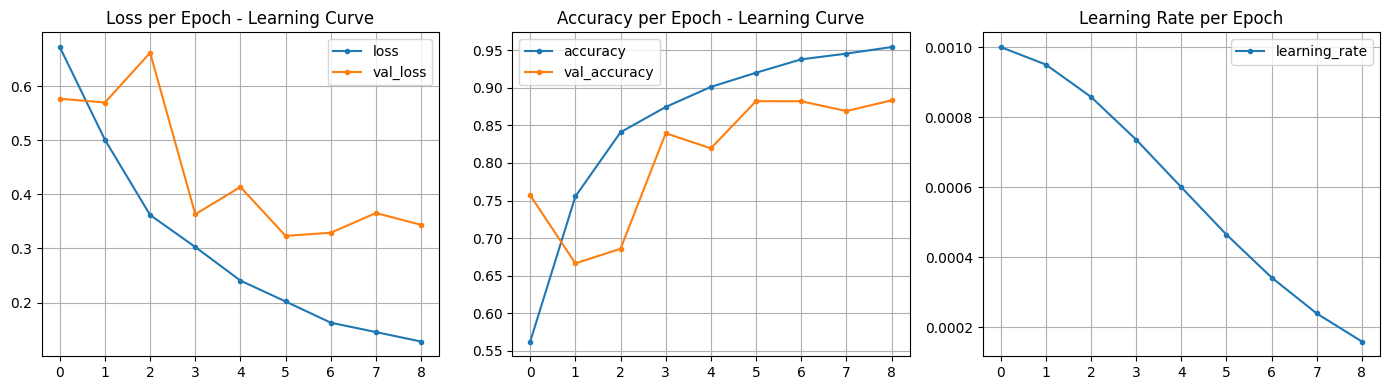

In [24]:
def learning_plots(history, figsize=(14,4)):
    import pandas as pd
    import matplotlib.pyplot as plt
    fig,axs=plt.subplots(1,3,figsize=figsize)
    results = pd.DataFrame(history)
    style = {"grid":True, "marker":".", "xticks":results.index}
    results[["loss" , "val_loss"]].plot(ax=axs[0],  title="Loss per Epoch - Learning Curve", **style)
    results[["accuracy" , "val_accuracy"]].plot(ax=axs[1],  title="Accuracy per Epoch - Learning Curve", **style)
    results[["learning_rate"]].plot(ax=axs[2],  title="Learning Rate per Epoch", **style)
    plt.tight_layout();

learning_plots(hist.history)

Model training stopped at epoch 6, as indicated by the learning rate above. This is also where the training-validation gap began to widen. Next, we will evaluate the model on a separate test set, make predictions based on some movie review samples I found online, and save the model in Keras format for our Gradio app.

In [47]:
# TEST SET EVALUATION

model.evaluate(test_ds)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8759 - loss: 0.3294


[0.32373496890068054, 0.8811200261116028]

In [141]:
# MAKE SOME PREDICTIONS

samples = keras.utils.text_dataset_from_directory("samples", labels=None, shuffle=False, batch_size=1)
true_labels = ["Negative", "Negative", "Positive", "Positive", "Negative"]

probs = model.predict(samples).round(3)

for i,j in enumerate(samples):
    print(f"{"="*100}\nREVIEW TEXT\n{j}\nTRUE LABEL: {true_labels[i]}\nPREDICTED LABEL: {"Positive" if probs[i] >= 0.5 else "Negative"}")

Found 5 files.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
REVIEW TEXT
[b'This was an absolutely terrible movie. Don\xe2\x80\x99t be lured in by the cast\xe2\x80\x94both great actors, but this is easily their worst role ever. Even their performances couldn\xe2\x80\x99t save the ridiculous storyline. The propaganda tone was overwhelming, and the plot made no sense at all.']
TRUE LABEL: Negative
PREDICTED LABEL: Negative
REVIEW TEXT
[b"Rich ditzy Joan Winfield is engaged to the egoistical Allen Brice and then gets kidnapped\xe2\x80\x94it all feels forced and dull. There's no genuine humor, despite repeated physical gags. Only the star power and nice cinematography keep it afloat, otherwise it\xe2\x80\x99s a slog to sit through."]
TRUE LABEL: Negative
PREDICTED LABEL: Negative
REVIEW TEXT
[b"Well, this film is a difficult one really. To be straight, it doesn\xe2\x80\x99t contain a riveting story, nor does it make you 'want' to know how it\xe2\x80\x99ll end... but I\xe2\x80\x99ve never been as t

In [142]:
# SAVE FINAL MODEL

model.save("saved_models/sentiment_model.keras")